# Structural Explanation and Predictive Analysis of Crime Rates in London

## Preparation

- [Github link](https://github.com/Weining5619/DSSS)

- Number of words: 1493

- Runtime: 2 m 52 s  (*Memory 24 GB, CPU Apple M3*)

- Coding environment: SDS Docker

- License: this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by/4.0/) (or other license that you like).

- Additional library *[libraries not included in SDS Docker or not used in this module]*:
    - **watermark**: A Jupyter Notebook extension for printing timestamps, version numbers, and hardware information.
    - **nbformat**: A library for reading, writing, and validating *.ipynb* files in Python.


In [1]:
#%pip install nbformat 
#%pip install watermark

In [2]:
# This chunk is for word counting
import nbformat
import os

# get the path of the current notebook file
notebook_path = os.getcwd()
notebook_path = os.path.join(os.getcwd(), "WeiningLI_submission_CASA0006.ipynb")


# read notebook file
with open(notebook_path, 'r', encoding='utf-8') as f:
    notebook = nbformat.read(f, as_version=4)

# skip the first 3 markdown cells (Title and Preparation)
markdown_cells = [cell for cell in notebook.cells if cell.cell_type == 'markdown']
markdown_cells = markdown_cells[3:-1]
filtered_cells = [cell for cell in markdown_cells if '<div align="center"><strong>' not in cell.source]

# count the number of words in all Markdown cells
total_words = sum(len(cell.source.split()) for cell in filtered_cells)
    
print(f"Total Markdown word count (excluding Title and Preparation): {total_words}")

Total Markdown word count (excluding Title and Preparation): 1493


In [3]:
# This chunk is for runtime counting

import time
start_time = time.time()

---

## Table of contents

1. [Introduction](#Introduction)

1. [Research questions](#Research-questions)

1. [Data](#Data)

1. [Methodology](#Methodology)

1. [Results and discussion](#Results-and-discussion)

1. [Conclusion](#Conclusion)

1. [References](#References)

## 1. Introduction

[[ go back to the top ]](#Table-of-contents)


Urban crime has long been recognised as a critical social issue affecting residents’ sense of safety and quality of life (Cozens, 2008). Understanding the structural and spatial distribution of urban crime is crucial to public safety governance in the UK. Crime rates are shaped not only by individual behaviour but are also deeply embedded in the socio-economic and residential structures of cities. As a representative global metropolis, London presents an ideal context for such analysis. This study adopts the LSOA as the spatial unit of analysis. Its finer spatial resolution enables the detection of neighbourhood-level variation in social and environmental conditions.

A large body of research confirms that crime is spatially patterned and closely tied to socio-economic disadvantage (Freeman, 1999; Finegan et al., 2020; Pazzona, 2024). Education (Lochner & Moretti, 2004), housing conditions (Cheng & Chen, 2021), and public transport access (Gallison & Andresen, 2017) have all been identified as relevant factors. These structural indicators offer critical insight into the geography of urban crime.


## 2. Research questions

[[ go back to the top ]](#Table-of-contents)

**To what extent can socio-economic and environmental structures explain and predict spatial variation in crime rates across London’s LSOAs?**

To address this overarching research question, the study is guided by the following sub-questions:
1. Are spatial crime patterns linked to distinctive structural characteristics across neighbourhoods?
2. Which dimensions of deprivation are most strongly associated with crime?
3. Do structural variables contain predictive signals for distinguishing between high- and low-crime areas? If so, which modelling approach provides the best predictive performance?

## 3. Data

[[ go back to the top ]](#Table-of-contents)

This study uses structural variables derived from the 2021 London Census at the LSOA level,including indicators such as low education, household language isolation, and unemployment, along with the Public Transport Accessibility Level (PTAL). In total, nine socio-economic and environmental variables are selected. The variables and their sources are listed in **Table 1**.


<div align="center"><strong>Table 1.</strong> Summary of input variables</div>

| **Variable**  | **Type** | **Description** | **Notes** | **Source** |
| :--------------- | :--------------- | :--------------- | :--------------- | :--------------- |
| **Total crime rate** | Numeric | Crime rate per 1,000 residents, averaged over 2021–2024 [1] and transformed using the Yeo-Johnson method to reduce skewness | Dependent variable | [MPS Recorded Crime: Geographic Breakdown](https://data.london.gov.uk/dataset/recorded_crime_summary) |
| **Low-education rate** | Numeric | Proportion of residents with no qualifications or only level 1-2 qualifications | Proxy for educational deprivation | [2011 Census](https://www.nomisweb.co.uk/sources/census_2021_bulk) |
| **Household language isolation rate** | Numeric | Proportion of households where no adult speaks English as a main language | Proxy for cultural isolation and communication barriers | Same as above |
| **Unemployment rate** | Numeric | Proportion of the economically active population who are unemployed | Proxy for income and labour market deprivation | Same as above |
| **Car or van unavailability rate** | Numeric | Proportion of households with no access to a car or van | Reflects both mobility limitations and potential economic disadvantage | Same as above |
| **Overcrowding rate** | Numeric | Proportion of households with occupancy rating of -1 or less | Reflects living environment | Same as above |
| **Poor health rate** | Numeric | Proportion of residents reporting ‘bad’ or ‘very bad’ health | Proxy for general health deprivation | Same as above |
| **Disability rate** | Numeric | Proportion of residents with functional limitations legally recognised as disabilities | Captures formally acknowledged structural vulnerability | Same as above |
| **Long-term sickness rate** [2] | Numeric | Proportion of residents with long-term physical or mental illness not formally classified as disabled | May indicate hidden vulnerability not captured by formal disability status | Same as above |
| **Public transport accessibility** | Numeric | Public transport accessibility index | Measures urban connectivity and mobility | [GLA PTAL dataset](https://data.london.gov.uk/dataset/public-transport-accessibility-levels) |
| **Geographical boundary** [3] | Shapefile | LSOA-level boundary geometry for mapping and spatial join | Used for visualisation and spatial analysis | [ONS Open Geography Portal](https://geoportal.statistics.gov.uk/) |


> Notes
> 
> [1]: The first reason why 2021–2024 period is chosen is because the most recent census was conducted in 2021. Given the short interval, the assumption of stable population characteristics is reasonable. Secondly, 2021 marks the beginning of the post-COVID period, which helps to minimise the confounding effects of the COVID-19 pandemic on crime patterns and socio-demographic variables. Finally, 2024 is the latest year with complete whole-year crime data.
>
> [2]: Criminal behaviour is often associated with physical and psychological vulnerability (Tan and Haining, 2016). One potentially overlooked group is those with long-term illness but no official disability status. While chronic or mental health issues may not limit daily activities, they might reduce social adaptability and, under pressure, relate to behaviours such as violence or defensive theft. To explore this possibility, long-term sickness is included as a variable. Both self-rated general health and legally defined disability are retained to offer a broader view of health-related disadvantage.
> 
> [3]: Of the 4,835 LSOAs in Greater London, only 4,659 contain valid crime data. Missing areas are typically non-residential (e.g. City of London, parks), or show no recorded crime. These are therefore removed.


#### Data pre-processing

In [4]:
# load all the packages first
import pandas as pd
import geopandas as gpd
import requests
import zipfile
from pathlib import Path
import numpy as np
from sklearn.preprocessing import PowerTransformer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib.gridspec as gridspec
from statsmodels.stats.stattools import durbin_watson
from sklearn.decomposition import PCA
from kneed import KneeLocator
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV



In [5]:
# read in LSOA crime data
df_recent = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/MPS%20LSOA%20Level%20Crime%20(most%20recent%2024%20months).csv")
df_historical = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/MPS%20LSOA%20Level%20Crime%20(Historical).csv")

# read in 2021 census data
df_residents = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/population.csv")
df_qualification = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/highest_level_of_qualification.csv")
df_language = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/household_language.csv")
df_economic_active = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/economic_active_status.csv")
df_car = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/car_or_van_availability.csv")
df_bedrooms = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/occupancy_rating_for_bedrooms.csv")
df_health = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/general_health.csv")
df_disability = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/disability.csv")

# read in PTAI data
df_PTAI = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/LSOA2011_AvPTAI2015.csv")

In [6]:
# download geo boundaries

# first download the zip file to the data folder, and then unzip it to data/LSOA_Boundaries_London/
# create a "data" folder（if do not exist）
data_dir = "data"
os.makedirs(data_dir, exist_ok=True)

# download the zip file (if do not exist)
zip_filename = "LSOA_Boundaries_London.zip"
zip_path = os.path.join(data_dir, zip_filename)

if not os.path.exists(zip_path):
    url = "https://github.com/Weining5619/DSSS/raw/main/data/LSOA_Boundaries_London.zip"
    response = requests.get(url)
    if response.status_code == 200:
        with open(zip_path, "wb") as f:
            f.write(response.content)
    else:
        raise Exception(f"Download failed. Status code: {response.status_code}")

# unzip the file (if do not exist)
extract_dir = os.path.join(data_dir, "LSOA_Boundaries_London")
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_dir)


In [7]:
# read in the shapefiles
# (It is a bit complicated here because the LSOA boundaries I found are stored by borough)

shp_folder = "data/LSOA_Boundaries_London"

# find all .shp files
shp_files = [
    shp for shp in Path(shp_folder).rglob("*.shp")
    if not shp.name.startswith("._") # exclude cache files generated by macOS when unzipping (e.g. ._xxx.shp), as they will cause errors.
]

# read them all into a gdf
gdf_list = [gpd.read_file(shp) for shp in shp_files]
gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True), crs=gdf_list[0].crs)

In [8]:
# conver crime data to long table
# first replace spaces in column names with underscores

def clean_columns(df):
    '''
    Unify the format of column names
    '''
    df.columns = df.columns.str.strip().str.replace(" ", "_")
    if "geography_code" in df.columns:
        df.rename(columns={"geography_code": "LSOA_Code"}, inplace=True)
    return df

df_recent = clean_columns(df_recent)

# find all the columns of months
date_cols_rec = [col for col in df_recent.columns if col.isdigit() and col < "202501"]

# conver to long table
df_recent_long = df_recent.melt(
    id_vars=["LSOA_Code", "LSOA_Name", "Borough", "Major_Category", "Minor_Category"],
    value_vars=date_cols_rec,
    var_name="YearMonth",
    value_name="CrimeCount"
)

# make it consistent with the number of LSOAs in gdf
df_recent_new = gdf[["LSOA11CD"]].copy()
df_recent_new = df_recent_new.rename(columns={"LSOA11CD": "LSOA_Code"})
df_recent_new = df_recent_new.merge(df_recent_long, on="LSOA_Code", how="left")

In [9]:
# do similar processing on historical crime data
df_historical = clean_columns(df_historical)

# drop columns before the year 2021
date_cols_his = [col for col in df_historical.columns if col.isdigit() and col >= "202101"]
cols_to_keep = ["LSOA_Code", "LSOA_Name", "Borough", "Major_Category", "Minor_Category"] + date_cols_his
df_historical = df_historical[cols_to_keep]

# conver to long table
df_historical_long = df_historical.melt(
    id_vars=["LSOA_Code", "LSOA_Name", "Borough", "Major_Category", "Minor_Category"],
    value_vars=date_cols_his,
    var_name="YearMonth",
    value_name="CrimeCount"
)

# make it consistent with the number of LSOAs in gdf
df_historical_new = gdf[["LSOA11CD"]].copy()
df_historical_new = df_historical_new.rename(columns={"LSOA11CD": "LSOA_Code"})
df_historical_new = df_historical_new.merge(df_historical_long, on="LSOA_Code", how="left")

In [10]:
# combine crime data of recent 24 months and historical
df_crime = pd.concat([df_historical_new, df_recent_new], ignore_index=True)

# count the number of crimes by year
df_crime["Year"] = df_crime["YearMonth"].str[:4] # extract the year
annual_crime_count = df_crime.groupby(["LSOA_Code", "Year"])["CrimeCount"].sum().reset_index()


In [11]:
# handle column names 
df_residents = clean_columns(df_residents)
df_residents = df_residents.rename(columns={"LSOA_code": "LSOA_Code"})
df_population = df_residents[["LSOA_Code", "All_usual_residents"]].copy()

# merge population and crime count
crime_rate = annual_crime_count.merge(df_population, on="LSOA_Code", how="left")

# calculate the number of cases per 1000 population as the crime rate
crime_rate["Crime_Rate_per_1000"] = crime_rate["CrimeCount"] / crime_rate["All_usual_residents"] * 1000

df_all = crime_rate[["LSOA_Code", "Year", "Crime_Rate_per_1000"]]

In [12]:
# process census data
df_qualification = clean_columns(df_qualification)
df_language = clean_columns(df_language)
df_economic_active = clean_columns(df_economic_active)
df_car = clean_columns(df_car)
df_bedrooms = clean_columns(df_bedrooms)
df_health = clean_columns(df_health)
df_disability = clean_columns(df_disability)
df_PTAI = clean_columns(df_PTAI)
df_PTAI = df_PTAI.rename(columns={"LSOA2011": "LSOA_Code"})

# drop all "date", "geography" columns to prevent duplicate columns which causes errors when merge
df_language.drop(columns=["date", "geography"], inplace=True, errors="ignore")
df_economic_active.drop(columns=["date", "geography"], inplace=True, errors="ignore")
df_car.drop(columns=["date", "geography"], inplace=True, errors="ignore")
df_bedrooms.drop(columns=["date", "geography"], inplace=True, errors="ignore")
df_health.drop(columns=["date", "geography"], inplace=True, errors="ignore")
df_disability.drop(columns=["date", "geography"], inplace=True, errors="ignore")

# merge all census as a combined dataframe
df_var = df_qualification.merge(df_language, on="LSOA_Code", how="left")
df_var = df_var.merge(df_economic_active, on="LSOA_Code", how="left")
df_var = df_var.merge(df_car, on="LSOA_Code", how="left")
df_var = df_var.merge(df_bedrooms, on="LSOA_Code", how="left")
df_var = df_var.merge(df_health, on="LSOA_Code", how="left")
df_var = df_var.merge(df_disability, on="LSOA_Code", how="left")
df_var = df_var.merge(df_PTAI, on="LSOA_Code", how="left")

# Keep only the data of London
London_LOSAs = gdf["LSOA11CD"].tolist()
df_var = df_var[df_var["LSOA_Code"].isin(London_LOSAs)].copy()

In [13]:
# process all the variables
# Low_Education_Rate = (No qualifications + Level1 + Level2) / All above 16
df_var["Low_Education_Rate"] = (
    df_var["Highest_level_of_qualification:_No_qualifications"] +
    df_var["Highest_level_of_qualification:_Level_1_and_entry_level_qualifications"] +
    df_var["Highest_level_of_qualification:_Level_2_qualifications"]
) / df_var["Highest_level_of_qualification:_Total:_All_usual_residents_aged_16_years_and_over"]

# Non_English_Household_Rate = (no English + no adults but children) / All
df_var["Non_English_Household_Rate"] = (
    df_var["Household_language_(English_and_Welsh):_No_people_in_household_have_English_in_England,_or_English_or_Welsh_in_Wales_as_a_main_language"] +
    df_var["Household_language_(English_and_Welsh):_No_adults_in_household,_but_at_least_one_person_aged_3_to_15_years,_has_English_in_England_or_English_or_Welsh_in_Wales_as_a_main_language"]
) / df_var["Household_language_(English_and_Welsh):_Total:_All_households"]

# Unemployed_Rate = unemployed (students + nonstudents) / All economically active
#   According to the standard definition of unemployment rate used by ONS and ILO, 
#   economically inactive people, such as students, retirees, and those taking care of families, are not included in the denominator.
df_var["Unemployed_Rate"] = (
    df_var["Economic_activity_status:_Economically_active_(excluding_full-time_students):_Unemployed"] +
    df_var["Economic_activity_status:_Economically_active_and_a_full-time_student:_Unemployed"]
) / (df_var["Economic_activity_status:_Total:_All_usual_residents_aged_16_years_and_over"]-
    df_var["Economic_activity_status:_Economically_inactive"])

# No_Car_Rate = No car / All
df_var["No_Car_Rate"] = df_var["Number_of_cars_or_vans:_No_cars_or_vans_in_household"] / df_var["Number_of_cars_or_vans:_Total:_All_households"]

# Overcrowding_Rate = lack of bedrooms / All
df_var["Overcrowding_Rate"] = (
    df_var["Occupancy_rating_for_bedrooms:_Occupancy_rating_of_bedrooms:_-1"] +
    df_var["Occupancy_rating_for_bedrooms:_Occupancy_rating_of_bedrooms:_-2_or_less"]
) / df_var["Occupancy_rating_for_bedrooms:_Total:_All_households"]

# Poor_Health_Rate = bad health + very bad / All
df_var["Poor_Health_Rate"] = (
    df_var["General_health:_Bad_health"] +
    df_var["General_health:_Very_bad_health"]
) / df_var["General_health:_Total:_All_usual_residents"]

# Disability_Rate = disabled / All
df_var["Disabled_Rate"] = df_var["Disability:_Disabled_under_the_Equality_Act"] / df_var["Disability:_Total:_All_usual_residents"]

# Long_Term_Sick_Rate = long-term sick / All
df_var["Long_Term_Sick_Rate"] = df_var["Disability:_Not_disabled_under_the_Equality_Act:_Has_long_term_physical_or_mental_health_condition_but_day-to-day_activities_are_not_limited"] / df_var["Disability:_Total:_All_usual_residents"]

# Public_Transport_Accessibility_Index
df_var["Public_Transport_Accessibility"] = df_var["AvPTAI2015"]

# merge the data obtained above into crime rate
col_vars = [
    "Low_Education_Rate",
    "Non_English_Household_Rate",
    "Unemployed_Rate",
    "No_Car_Rate",
    "Overcrowding_Rate",
    "Poor_Health_Rate",
    "Disabled_Rate",
    "Long_Term_Sick_Rate",
    "Public_Transport_Accessibility"
]
df_var_only = df_var[["LSOA_Code"] + col_vars]
df_all = df_all.merge(df_var_only, on=["LSOA_Code"], how="left")

In [14]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18612 entries, 0 to 18611
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   LSOA_Code                       18612 non-null  object 
 1   Year                            18612 non-null  object 
 2   Crime_Rate_per_1000             18612 non-null  float64
 3   Low_Education_Rate              18612 non-null  float64
 4   Non_English_Household_Rate      18612 non-null  float64
 5   Unemployed_Rate                 18612 non-null  float64
 6   No_Car_Rate                     18612 non-null  float64
 7   Overcrowding_Rate               18612 non-null  float64
 8   Poor_Health_Rate                18612 non-null  float64
 9   Disabled_Rate                   18612 non-null  float64
 10  Long_Term_Sick_Rate             18612 non-null  float64
 11  Public_Transport_Accessibility  18612 non-null  float64
dtypes: float64(10), object(2)
memory

#### Checking Data Distribution
Some variables, such as Public_Transport_Accessibility and Unemployed_Rate, showed heavy skewness. To reduce their impact, log transformations were applied. This helps stabilise the distribution without removing potentially important features. The results, as shown in **Figure 2**, are within an acceptable range.

In [15]:
# log transformation
epsilon = 1e-6

df_all["Crime_Rate_log"] = np.log(df_all["Crime_Rate_per_1000"] + epsilon)
df_all["PTA_log"] = np.log(df_all["Public_Transport_Accessibility"] + epsilon)
df_all["Unemployed_Rate_log"] = np.log(df_all["Unemployed_Rate"] + epsilon)

# Yeo-Johnson
pt = PowerTransformer(method='yeo-johnson')
df_all['Crime_Rate_yj'] = pt.fit_transform(df_all[['Crime_Rate_per_1000']])


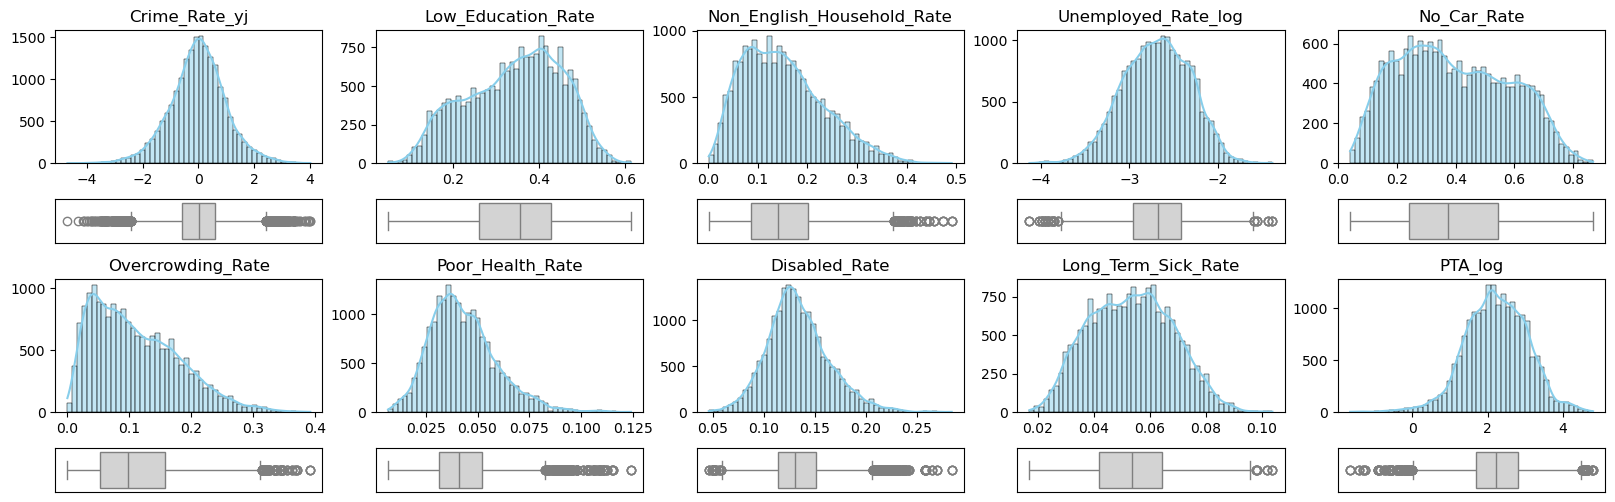

In [16]:
# plot the distribution of all variables
cols_to_plot = [
    "Crime_Rate_yj",
    "Low_Education_Rate",
    "Non_English_Household_Rate",
    "Unemployed_Rate_log",
    "No_Car_Rate",
    "Overcrowding_Rate",
    "Poor_Health_Rate",
    "Disabled_Rate",
    "Long_Term_Sick_Rate",
    "PTA_log"
]

fig = plt.figure(figsize=(20, 6))
gs = gridspec.GridSpec(4, 5, height_ratios=[3, 1, 3, 1], hspace=0.4)

for i, col in enumerate(cols_to_plot):
    col_index = i % 5
    row_base = (i // 5) * 2  # each group occupies two lines

    # Up: Histogram (height*3)
    ax_hist = fig.add_subplot(gs[row_base, col_index])
    sns.histplot(df_all[col], kde=True, bins=50, color='skyblue', ax=ax_hist)
    ax_hist.set_title(col, fontsize=12)
    ax_hist.set_xlabel("")
    ax_hist.set_ylabel("")
    ax_hist.tick_params(axis='x', labelsize=10)
    ax_hist.tick_params(axis='y', labelsize=10)

    # Down: Box plot (height*1)
    ax_box = fig.add_subplot(gs[row_base + 1, col_index])
    sns.boxplot(x=df_all[col], color='lightgray', ax=ax_box)
    ax_box.set_xlabel("")
    ax_box.set_xticks([]) # remobe x, y axis ticks
    ax_box.set_yticks([])

plt.show()

<div align="center"><strong>Figure 2.</strong> Distribution of variables</div>

## 4. Methodology

[[ go back to the top ]](#Table-of-contents)

The workflow of methodology is summarised in **Figure 3**.

![Methodology_workflow](./Methodology_workflow.png)
<div align="center"><strong>Figure 3.</strong> Methodology workflow </div>

### 4.1. PCA

To avoid highly correlated variables dominating the clustering process and skewing results, and to reduce multicollinearity in regression models, the correlation matrix was examine first.

As shown in **Figure 4**, most variables are approximately normally distributed and linearly related. Therefore, Pearson correlation coefficients are calculated to assess pairwise associations (**Figure5**).


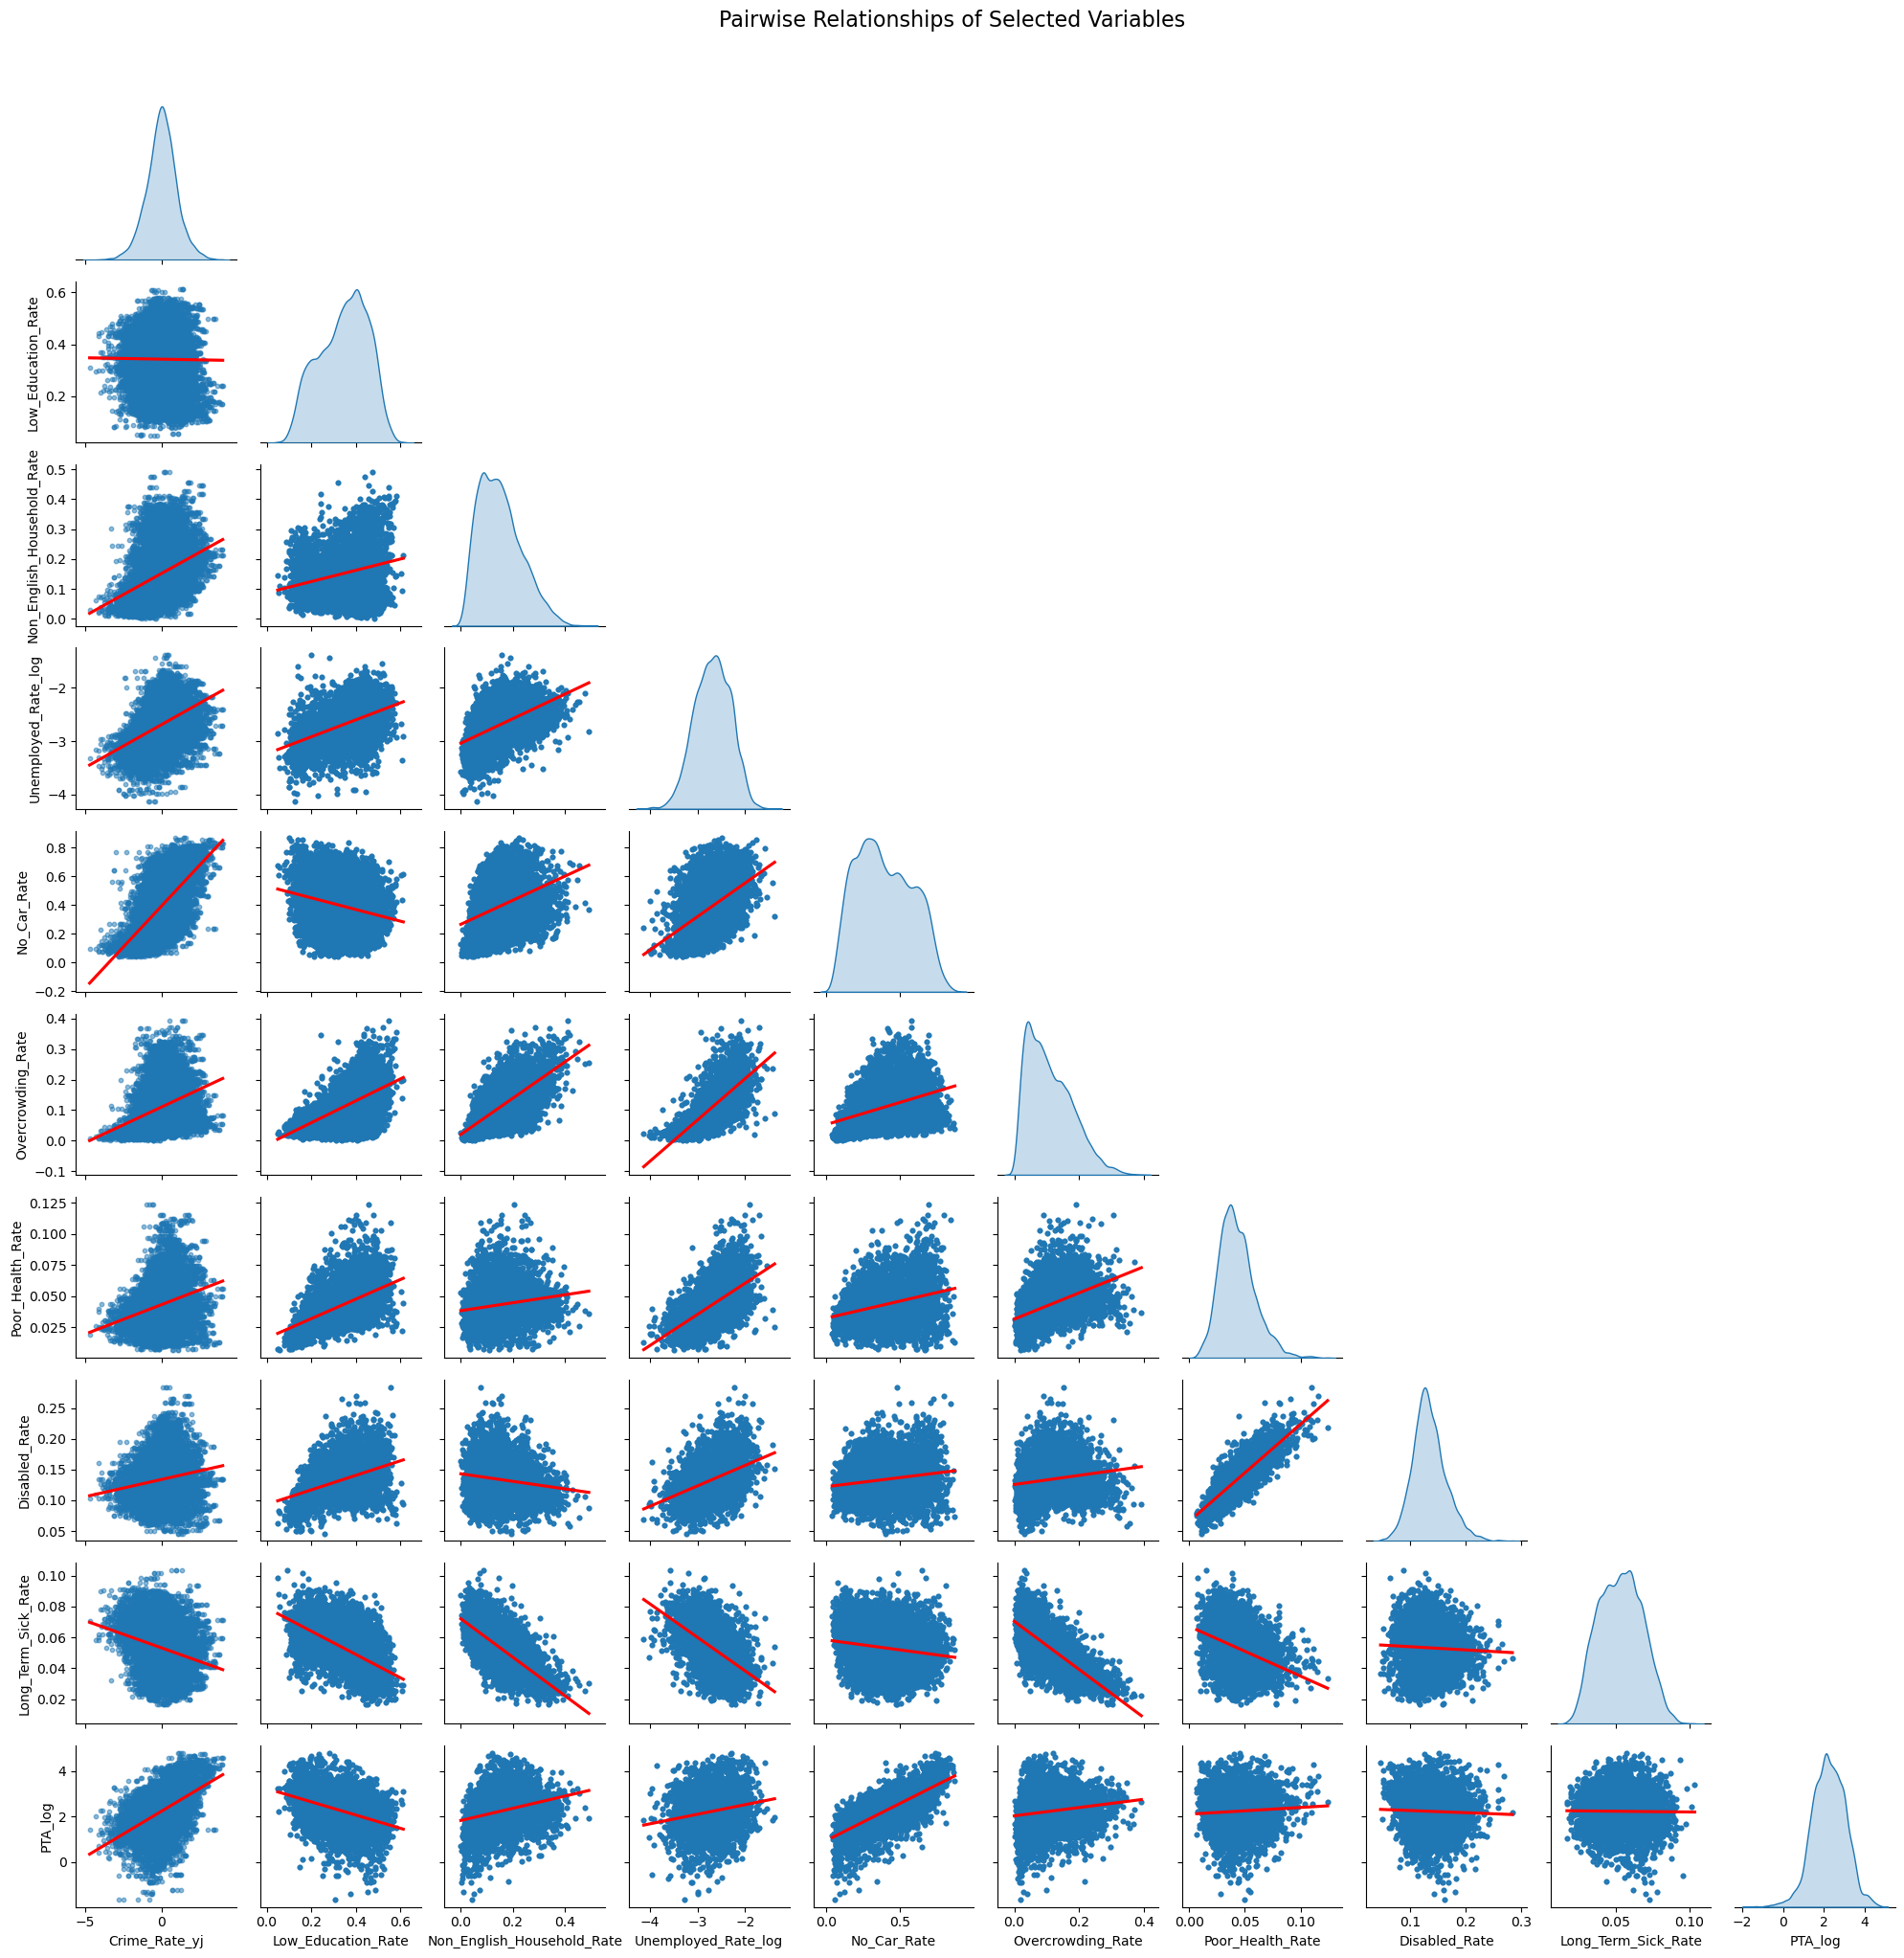

In [17]:
sns.pairplot(
    df_all[cols_to_plot],
    diag_kind="kde", 
    kind="reg", # add reg line on the scatter plot
    corner=True,   # only show the lower triangle
    height=2, 
    plot_kws={"line_kws": {"color": "red"},
              "scatter_kws": {"s": 10, "alpha": 0.5}} 
)

plt.suptitle("Pairwise Relationships of Selected Variables", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

<div align="center"><strong>Figure 4.</strong> Pairwise Relationships of Selected Variables</div>

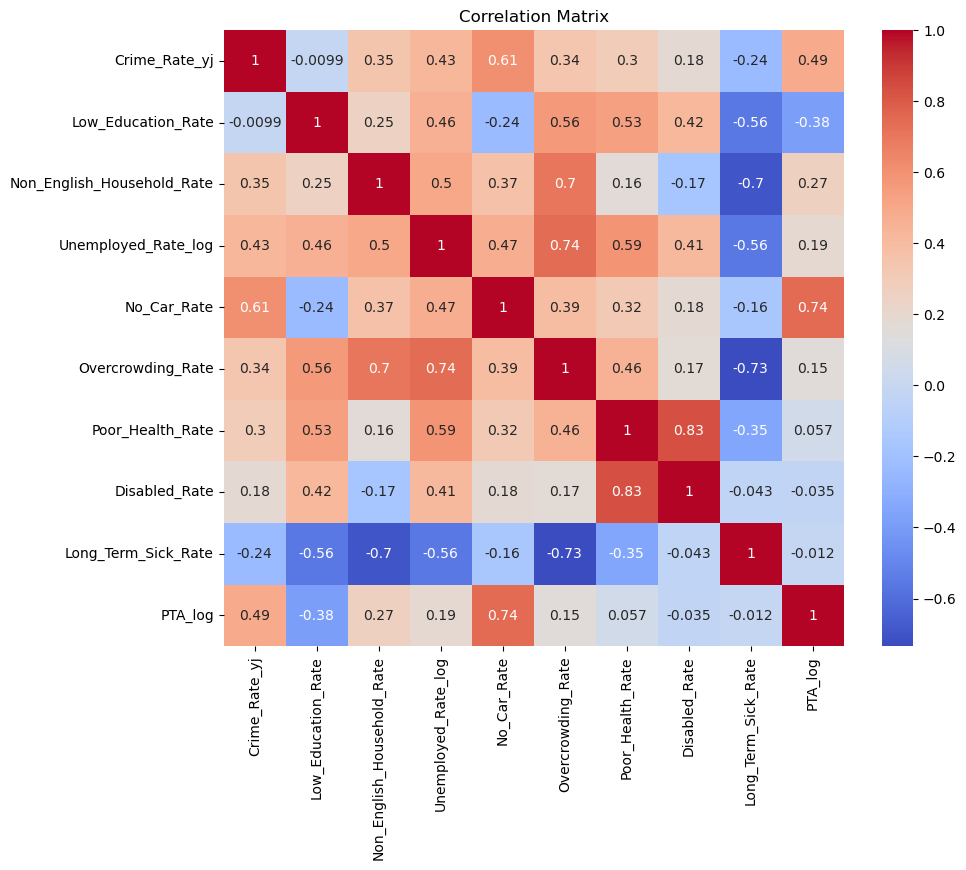

In [18]:
# calculate the correlation matrix
corr_matrix = df_all[cols_to_plot].corr(method="pearson")

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

<div align="center"><strong>Figure 5.</strong> Correlation Matrix </div>

As shown in the correlation matrix (**Figure 5**), several variables are highly correlated. This would lead to unstable regression coefficients, inflated variable effects, and reduced interpretability.


To address this while retaining most of the underlying information, PCA was applied to compress them into a smaller number of uncorrelated components.


#### PCA


In [19]:
# select variable columns for dimensionality reduction
cols_for_pca = [
    "Low_Education_Rate",
    "Non_English_Household_Rate",
    "Unemployed_Rate_log",
    "No_Car_Rate",
    "Overcrowding_Rate",
    "Poor_Health_Rate",
    "Disabled_Rate",
    "Long_Term_Sick_Rate",
    "PTA_log"
]
# Here, I still choose the logarithmically transformed Crime_Rate and Public_Transport_Accessibility 
# that are more inclined to a normal distribution. 
# This is because if the original variable is highly skewed (especially severely right-skewed), 
# a few extreme values will dominate the variance explanation. Therefore, for the previously severely skewed variables.

# standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_all[cols_for_pca])

# Initialize PCA
rand_st_int = 5525 
pca = PCA(random_state=rand_st_int)

X_pca = pca.fit_transform(X_scaled)

print(f"Number of PCs retained: {pca.n_components_}")
print(f"Explained variance ratio of each component: {pca.explained_variance_ratio_}")

# add the principal component results to the original table
for i in range(pca.n_components_):
    df_all[f"PCA_{i+1}"] = X_pca[:, i]

Number of PCs retained: 9
Explained variance ratio of each component: [0.44484783 0.23071704 0.18342958 0.03959046 0.03083549 0.02533328
 0.02180343 0.01267983 0.01076306]


In [20]:
# show the PCA Loadings Matrix
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=cols_for_pca
)
display(loadings.round(2))

PC1   PC2   PC3   PC4   PC5   PC6   PC7   PC8  \
Low_Education_Rate          0.31 -0.46 -0.14 -0.12  0.57  0.19  0.00  0.53   
Non_English_Household_Rate  0.34  0.25 -0.39 -0.22 -0.42  0.57 -0.31  0.14   
Unemployed_Rate_log         0.43  0.03  0.07  0.71 -0.01 -0.21 -0.50  0.01   
No_Car_Rate                 0.24  0.50  0.30  0.11 -0.14 -0.07  0.50  0.56   
Overcrowding_Rate           0.44  0.05 -0.21  0.22  0.25  0.23  0.52 -0.54   
Poor_Health_Rate            0.36 -0.22  0.41 -0.29 -0.24  0.06  0.04 -0.27   
Disabled_Rate               0.23 -0.30  0.57 -0.14 -0.13  0.07 -0.10 -0.00   
Long_Term_Sick_Rate        -0.38  0.03  0.37  0.38  0.13  0.73 -0.02  0.00   
PTA_log                     0.11  0.58  0.24 -0.35  0.57 -0.02 -0.35 -0.17   

                             PC9  
Low_Education_Rate         -0.12  
Non_English_Household_Rate  0.09  
Unemployed_Rate_log        -0.10  
No_Car_Rate                -0.04  
Overcrowding_Rate           0.18  
Poor_Health_Rate           -0.66  
Disabled_Rate               0.69  
Long_Term_Sick_Rate        -0.14  
PTA_log                     0.01

<div align="center"><strong>Table 2.</strong> PCA Loadings Matrix </div>

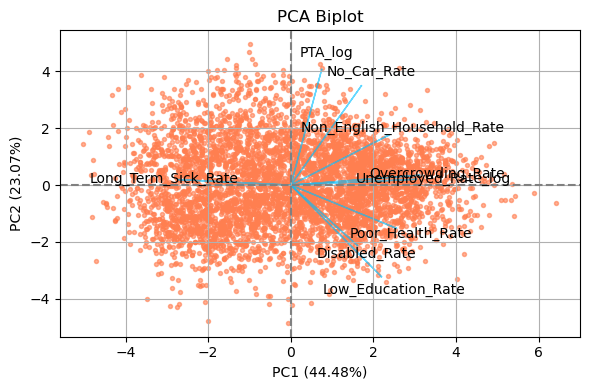

In [21]:
# extract the scores of the first two PCs and draw Biplot
# The figures drawn by 'bioinfokit' are not easy to modify, so use matplotlib to draw.
plt.figure(figsize=(6, 4))
xs = X_pca[:, 0]
ys = X_pca[:, 1]
plt.scatter(xs, ys, alpha=0.2, color="coral", s=8)

for i, var in enumerate(cols_for_pca):
    plt.arrow(0, 0,
              pca.components_[0, i]*7,
              pca.components_[1, i]*7,
              color='deepskyblue', alpha=0.6, head_width=0.02)
    plt.text(pca.components_[0, i]*8,
             pca.components_[1, i]*8,
             var, fontsize=10, ha="center", va="center")

plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0, color="gray", linestyle="--")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.title("PCA Biplot")
plt.grid(True)
plt.tight_layout()
plt.show()

<div align="center"><strong>Figure 6.</strong> PCA Biplot </div>

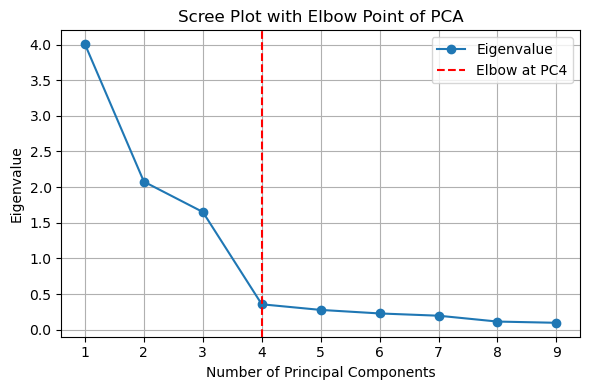

In [22]:
# use Scree plot to locate a point that occurs just before the Scree plot flattens out
eigenvalues = pca.explained_variance_
pcs = list(range(1, len(eigenvalues) + 1))

# use KneeLocator to find the elbow.
knee = KneeLocator(pcs, eigenvalues, curve='convex', direction='decreasing')

plt.figure(figsize=(6, 4))
plt.plot(pcs, eigenvalues, marker='o', label='Eigenvalue')
plt.axvline(x=knee.knee, color='red', linestyle='--', label=f'Elbow at PC{knee.knee}')
plt.title("Scree Plot with Elbow Point of PCA")
plt.xlabel("Number of Principal Components")
plt.ylabel("Eigenvalue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<div align="center"><strong>Figure 7.</strong> Scree Plot with Elbow Point of PCA </div>

In [23]:
variance_explained = pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1] + pca.explained_variance_ratio_[2] + pca.explained_variance_ratio_[3]
print(f"Proportion of variance explained by PC1 to PC4: {variance_explained:.2%}")

Proportion of variance explained by PC1 to PC4: 89.86%


Based on the elbow point in the scree plot (**Figure**), the first 4 principal components were retained, explaining 89.86% of the total variance.

 - PC1 reflects general socioeconomic disadvantage, with high scores in areas of low education, unemployment, poor health, overcrowding, and limited transport access.
 - PC2 captures urban connectivity, positively associated with public transport access, education, and vehicle ownership.
 - PC3 represents language isolation, driven mainly by the proportion of non-English-speaking households.
 - PC4 relates to health conditions, influenced by poor health and long-term sickness rates.

PCA effectively reduced dimensionality while preserving key structural information, supporting more stable clustering and regression analyses.



### 4.2. Clustering

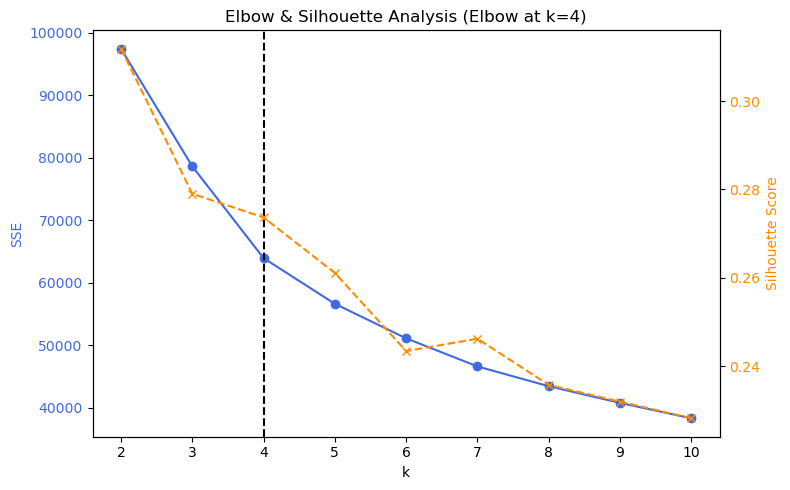

In [24]:
X = df_all[['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4']]

k_range = range(2, 11)
sse = []
silhouette = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=5525, n_init=10)
    labels = kmeans.fit_predict(X)
    sse.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X, labels))

# find elbow
kl = KneeLocator(k_range, sse, curve='convex', direction='decreasing')
elbow_k = kl.elbow

# plot
fig, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()

ax1.plot(k_range, sse, marker='o', color='royalblue', label='SSE (Distortion)')
ax1.axvline(elbow_k, linestyle='--', color='black', label=f'Elbow at k={elbow_k}')
ax1.set_xlabel("k")
ax1.set_ylabel("SSE", color='royalblue')
ax1.tick_params(axis='y', labelcolor='royalblue')

ax2.plot(k_range, silhouette, marker='x', linestyle='--', color='darkorange', label='Silhouette Score')
ax2.set_ylabel("Silhouette Score", color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

plt.title(f"Elbow & Silhouette Analysis (Elbow at k={elbow_k})")
plt.tight_layout()
plt.show()

<div align="center"><strong>Figure 8.</strong> Elbow & Silhouette Analysis </div>

As vividly shown in **Figure 8** the elbow method suggests k = 4, and the silhouette scores are relatively high at this point.

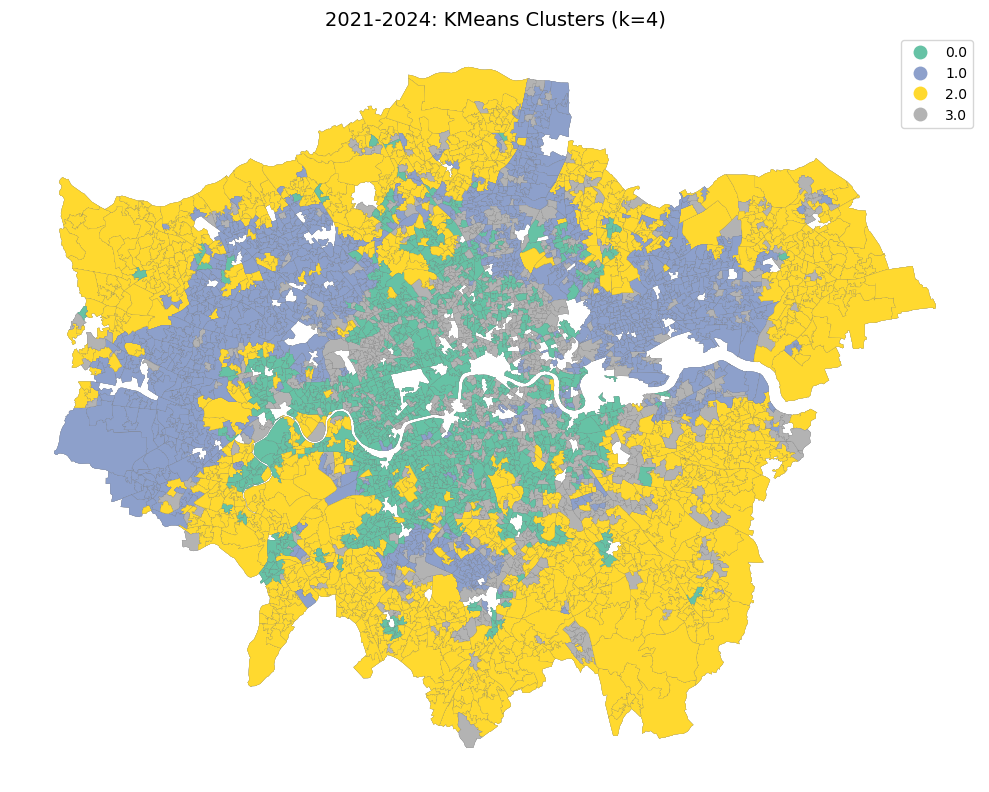

In [25]:
gdf_c_plot = gdf.copy()
gdf_c_plot = gdf_c_plot.rename(columns={"LSOA11CD": "LSOA_Code"})

X = df_all[['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4']]
lsoa_codes = df_all["LSOA_Code"].values

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=5525, n_init=10)
labels = kmeans.fit_predict(X)

# merge the cluster labels with the gdf
df_clustered = pd.DataFrame({"LSOA_Code": lsoa_codes, "cluster": labels})
gdf_plot = gdf_c_plot.merge(df_clustered, on="LSOA_Code", how="left")

fig, ax = plt.subplots(figsize=(10, 8))
gdf_plot.plot(
    column="cluster",
    categorical=True,
    legend=True,
    cmap="Set2",
    linewidth=0.1,
    edgecolor="grey",
    ax=ax
)
ax.set_title("2021-2024: KMeans Clusters (k=4)", fontsize=14)
ax.axis("off")

plt.tight_layout()
plt.show()

<div align="center"><strong>Figure 9.</strong> KMeans Clusters </div>

In [26]:
# print the average PC score of each cluster
df_all['cluster'] = labels
print(df_all.groupby('cluster')[['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4']].mean())

            PCA_1     PCA_2     PCA_3     PCA_4
cluster                                        
0       -1.396080  1.621061  0.239188  0.025322
1        1.661418 -0.081466 -1.289811  0.005961
2       -1.773209 -1.184461 -0.048706 -0.013704
3        1.769938 -0.126356  1.389657 -0.017086


The clustering maps (**Figure 9**) reveal some spatial variation over time, particularly in central and edge areas, highlighting the socio-economic heterogeneity across London’s LSOAs. Based on the scores of four PCs above, the KMeans algorithm identifies four distinct residential types:

- **Cluster 0** represents relatively affluent areas with good public transport access and a high proportion of non-English-speaking households.
- **Cluster 1** includes socioeconomically disadvantaged but lower-density zones, often located at the urban–suburban fringe.
- **Cluster 2** shows the most advantaged profile—higher income, better education, and stable housing—but with weaker transport connectivity.
- **Cluster 3** captures areas with severe deprivation, overcrowding, and cultural isolation, likely reflecting high-density social housing.

The spatial pattern of clusters broadly aligns with the crime rate heatmaps (**Figure 10**), especially in inner and outer LSOAs.  Clusters 1 and 3 are associated with higher crime, while Clusters 0 and 2 tend to show lower crime rates. The contrast in crime levels across clusters supports the reason for further regression analysis.

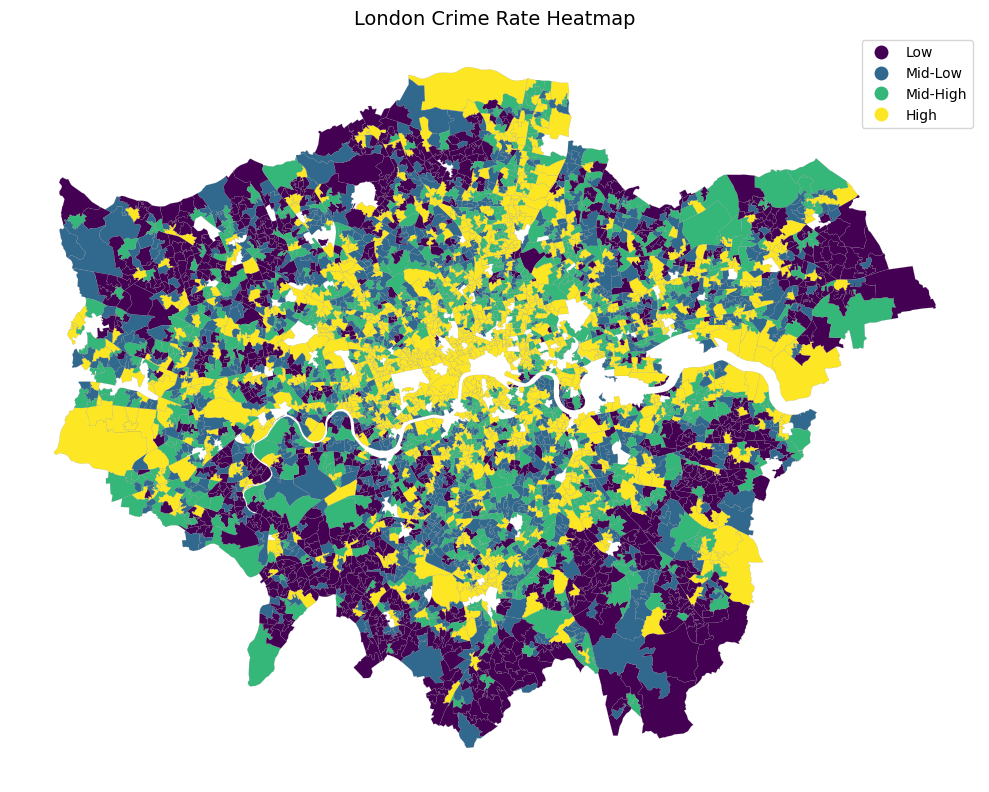

In [27]:
df_year = df_all.groupby('LSOA_Code')['Crime_Rate_per_1000'].mean().reset_index()

pt = PowerTransformer(method='yeo-johnson')
df_year['Crime_Rate_yj'] = scaler.fit_transform(df_year[['Crime_Rate_per_1000']])

fig, ax = plt.subplots(figsize=(10, 8))

gdf_crime = gdf_c_plot.copy()
gdf_crime = gdf_crime.merge(df_year, on="LSOA_Code", how="left")

gdf_crime['Crime_Quartile'] = pd.qcut(gdf_crime['Crime_Rate_yj'], q=4, labels=["Low", "Mid-Low", "Mid-High", "High"])

gdf_crime.plot(
    column='Crime_Quartile',
    cmap='viridis',
    categorical=True,
    legend=True,
    linewidth=0.1,
    edgecolor='grey',
    ax=ax
)

ax.set_title("London Crime Rate Heatmap", fontsize=14)
ax.axis("off")

plt.tight_layout()
plt.show()

<div align="center"><strong>Figure 10.</strong> London Crime Rate Heatmap </div>

### 4.2. Liner Regression


#### Check Assumptions

<Figure size 600x400 with 0 Axes>

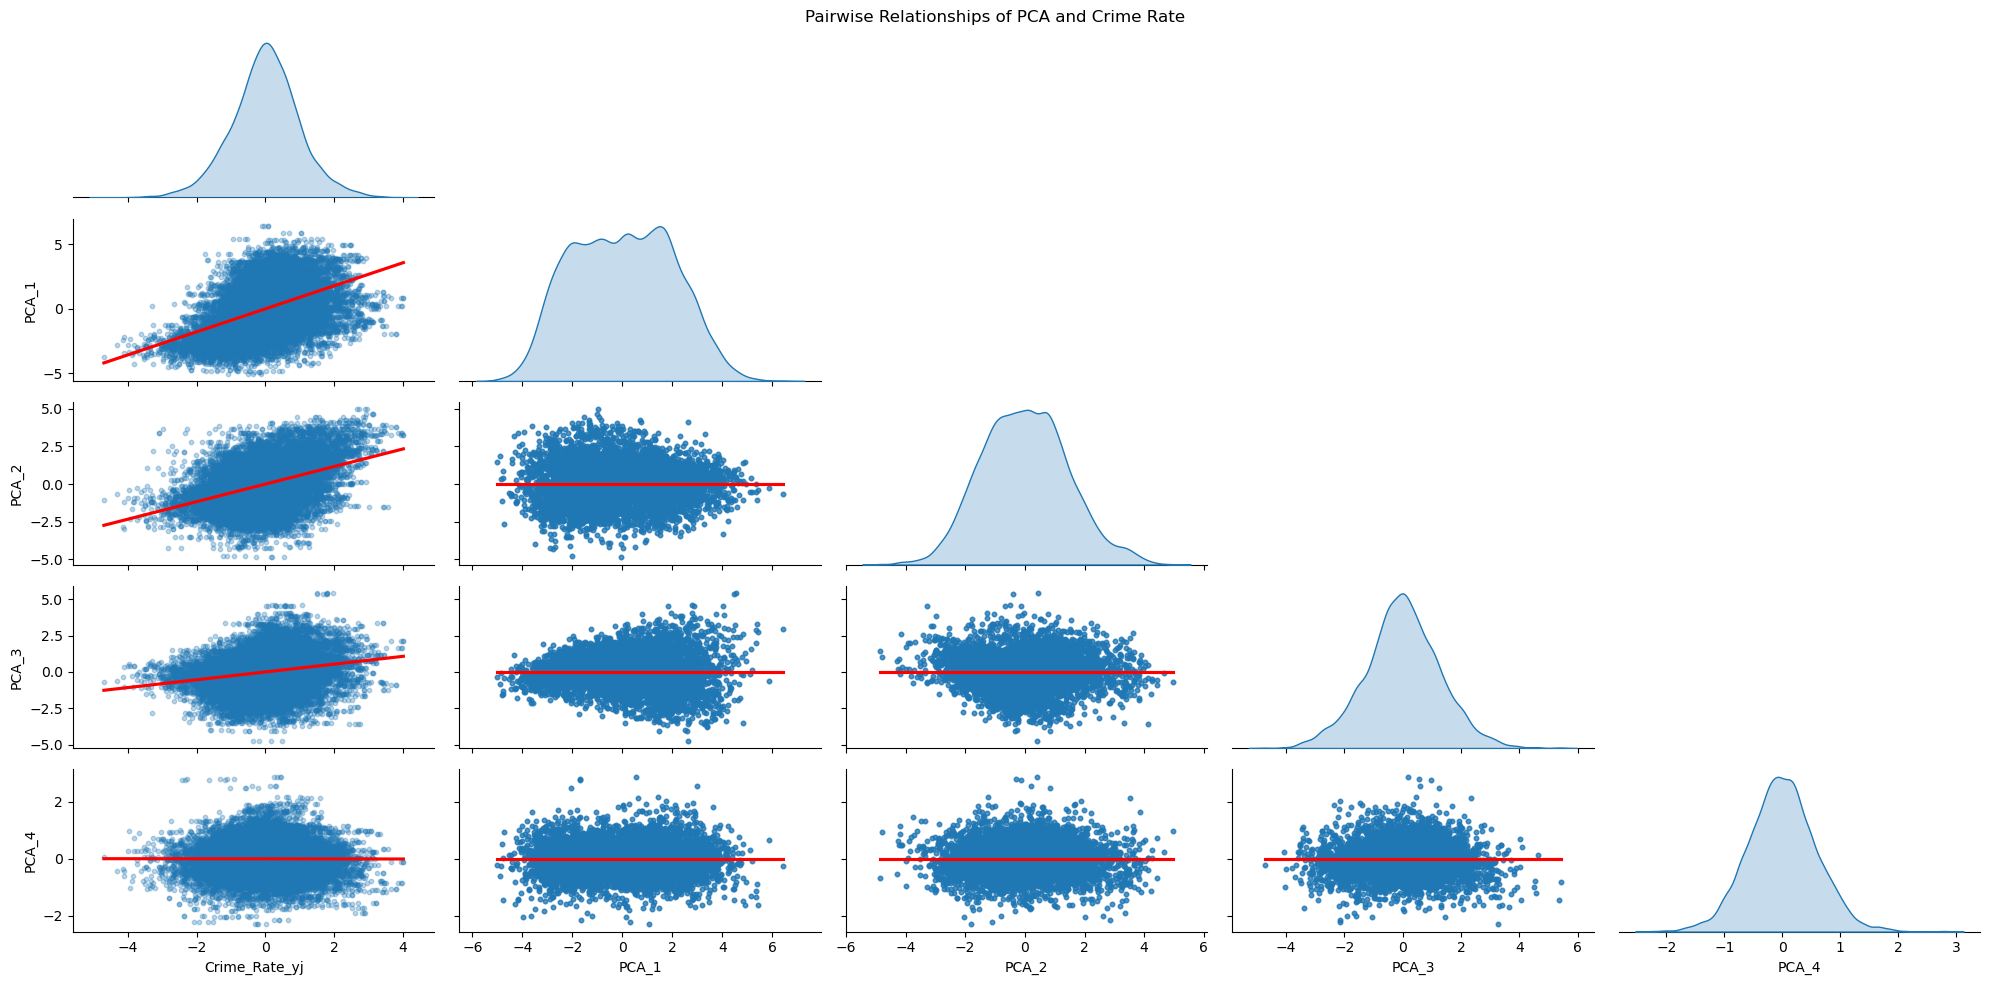

In [28]:
# A. Linearity
plt.figure(figsize=(6, 4))

sns.pairplot(
    df_all[["Crime_Rate_yj", "PCA_1", "PCA_2", "PCA_3", "PCA_4"]],
    diag_kind="kde",
    kind="reg",
    corner=True,
    height=2, 
    aspect=2, #the picture is compressed here for typesetting
    plot_kws={"line_kws": {"color": "red"}, 
              "scatter_kws": {"alpha": 0.3, "s": 10}}
)

plt.suptitle("Pairwise Relationships of PCA and Crime Rate", fontsize=12)
plt.tight_layout()
plt.show()


<div align="center"><strong>Figure 11.</strong> Pairwise Relationships of PCA and Crime Rate </div>

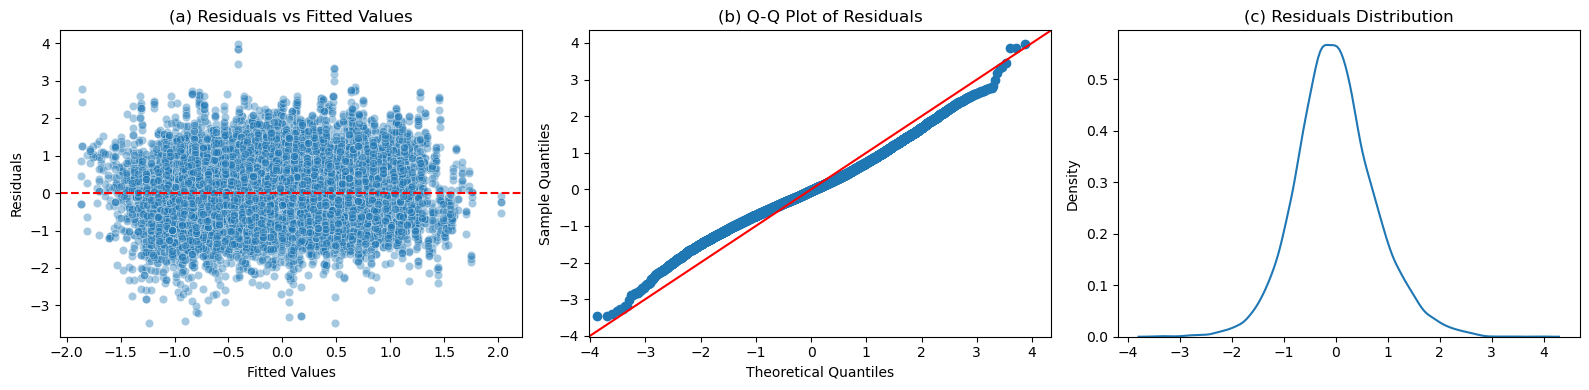

Durbin-Watson statistic: 0.6487436928814837


In [29]:
# fit the model
X = df_all[["PCA_1", "PCA_2", "PCA_3", "PCA_4"]]
X = sm.add_constant(X)
y = df_all["Crime_Rate_yj"]

model = sm.OLS(y, X).fit()


fig, axs = plt.subplots(1, 3, figsize=(16, 4))

# B. Homoscedasticity
# left：Residuals vs Fitted
fitted_vals = model.fittedvalues
residuals = model.resid
sns.scatterplot(x=fitted_vals, y=residuals, alpha=0.4, ax=axs[0])
axs[0].axhline(0, color='red', linestyle='--')
axs[0].set_xlabel("Fitted Values")
axs[0].set_ylabel("Residuals")
axs[0].set_title("(a) Residuals vs Fitted Values")

# C. Normality of residuals
# middle：Q-Q plot
sm.qqplot(residuals, line='45', ax=axs[1])
axs[1].set_title("(b) Q-Q Plot of Residuals")

# right：KDE plot
sns.kdeplot(residuals, ax=axs[2])
axs[2].set_title("(c) Residuals Distribution")

plt.tight_layout()
plt.show()


# D. Independence of errors
dw_stat = durbin_watson(model.resid) 
print("Durbin-Watson statistic:", dw_stat)


<div align="center"><strong>Figure 12.</strong> Homoscedasticity and Normality of residuals test </div>

Model assumptions were checked across five aspects.

**A. Linearity**: Scatterplots and fitted lines from **Figure 11** suggest a roughly linear relationship between most PCs and crime rate.

**B. Homoscedasticity**: The residuals vs. fitted plot (**Figure 12 - a**) shows a cloud-like pattern without funnel shapes, indicating fairly constant variance.

**C. Normality of residuals**: The QQ plot (**Figure 12 - b**) and KDE plot (**Figure 12 - c**) show residuals are approximately normal.

**D. Independence of errors**: The Durbin–Watson statistic is below 2 suggests positive autocorrelation, possibly due to the static nature of census-based variables across 2021–2024.

**E. Multicollinearity**: Addressed through PCA.

The model is specified as follows.

#### Linear Regression Results

In [30]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Crime_Rate_yj   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     3181.
Date:                Mon, 21 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:46:59   Log-Likelihood:                -21560.
No. Observations:               18612   AIC:                         4.313e+04
Df Residuals:                   18607   BIC:                         4.317e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.254e-15      0.006   3.99e-13      1.0

The PCA-based OLS regression explains approximately 40.6% of the variance in crime rate (R² = 0.406). All components included in the model are statistically significant (p < 0.001) except for PC4, suggesting that the retained socio-economic structural variables are relevant, but not fully explanatory.

The fitted model:

Crime_Rate_yj = 0.2230 × PC1 + 0.2804 × PC2 + 0.1629 × PC3

In [31]:
# extract the loading matrix W (variables × PC) of the first four principal components.
W = loadings.iloc[:, :3].values  # shape: (num_vars, 3)

# extract their regression coefficients β
beta_vector = np.array([0.2230, 0.2804, 0.1629])  # shape: (3,)

# Calculate the coefficient θ of the restored variable.
theta = W @ beta_vector  # shape: (num_vars,)

original_coef = pd.DataFrame({
    'variable': loadings.index,
    'coefficient': theta
}).sort_values(by='coefficient', ascending=False)

print(original_coef.round(4))

                     variable  coefficient
3                 No_Car_Rate       0.2433
8                     PTA_log       0.2258
2         Unemployed_Rate_log       0.1164
5            Poor_Health_Rate       0.0870
1  Non_English_Household_Rate       0.0821
4           Overcrowding_Rate       0.0793
6               Disabled_Rate       0.0593
7         Long_Term_Sick_Rate      -0.0179
0          Low_Education_Rate      -0.0823


To enhance interpretability, the original variable-level coefficients were recovered using the formula:

Crime_Rate_yj = X · θ = X · (W × β)

where:

- X is matrix of original (standardised) variables;
- W is the loadings matrix from PCA;
- θ represents recovered coefficients for the original variables;
- β represents the regression coefficients for retained components. 
  
This back-transformation allows for estimating the individual effect of each original feature on the crime rate and better understand the structural drivers behind it: transport access, car ownership and Unemployment are among the strongest predictors of crime rate, followed by health-related and culture isolation (non-english) indicators.

### 4.4. Machine Learning
Based on this, a set of predictive models was implemented to further assess the explanatory power of structural variables. Linear Regression, Lasso, Support Vector Regression (SVR), Random Forest, and XGBoost were applied and compared under consistent settings, including the same train-test split, standardised inputs, and evaluation metrics (R² and RMSE).



In [32]:
# separate features and targets
features = [
    "Low_Education_Rate",
    "Non_English_Household_Rate",
    "Unemployed_Rate_log",
    "No_Car_Rate",
    "Overcrowding_Rate",
    "Poor_Health_Rate",
    "Disabled_Rate",
    "Long_Term_Sick_Rate",
    "PTA_log"
]
X = df_all[features]
y = df_all["Crime_Rate_yj"]

# split training/testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5525)

#standardization (only fit on the training set)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# set up models
models = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(alpha=0.1, random_state=5525),
    "SVR": SVR(kernel='rbf'),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=5525),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=5525, verbosity=0),
}

# training and evaluation
results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results.append({
        "Model": name,
        "R²": r2_score(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred))
    })

results_df = pd.DataFrame(results)
print(results_df)

              Model        R²      RMSE
0  LinearRegression  0.409688  0.765884
1             Lasso  0.386709  0.780648
2               SVR  0.537408  0.677986
3      RandomForest  0.855679  0.378692
4           XGBoost  0.529260  0.683931


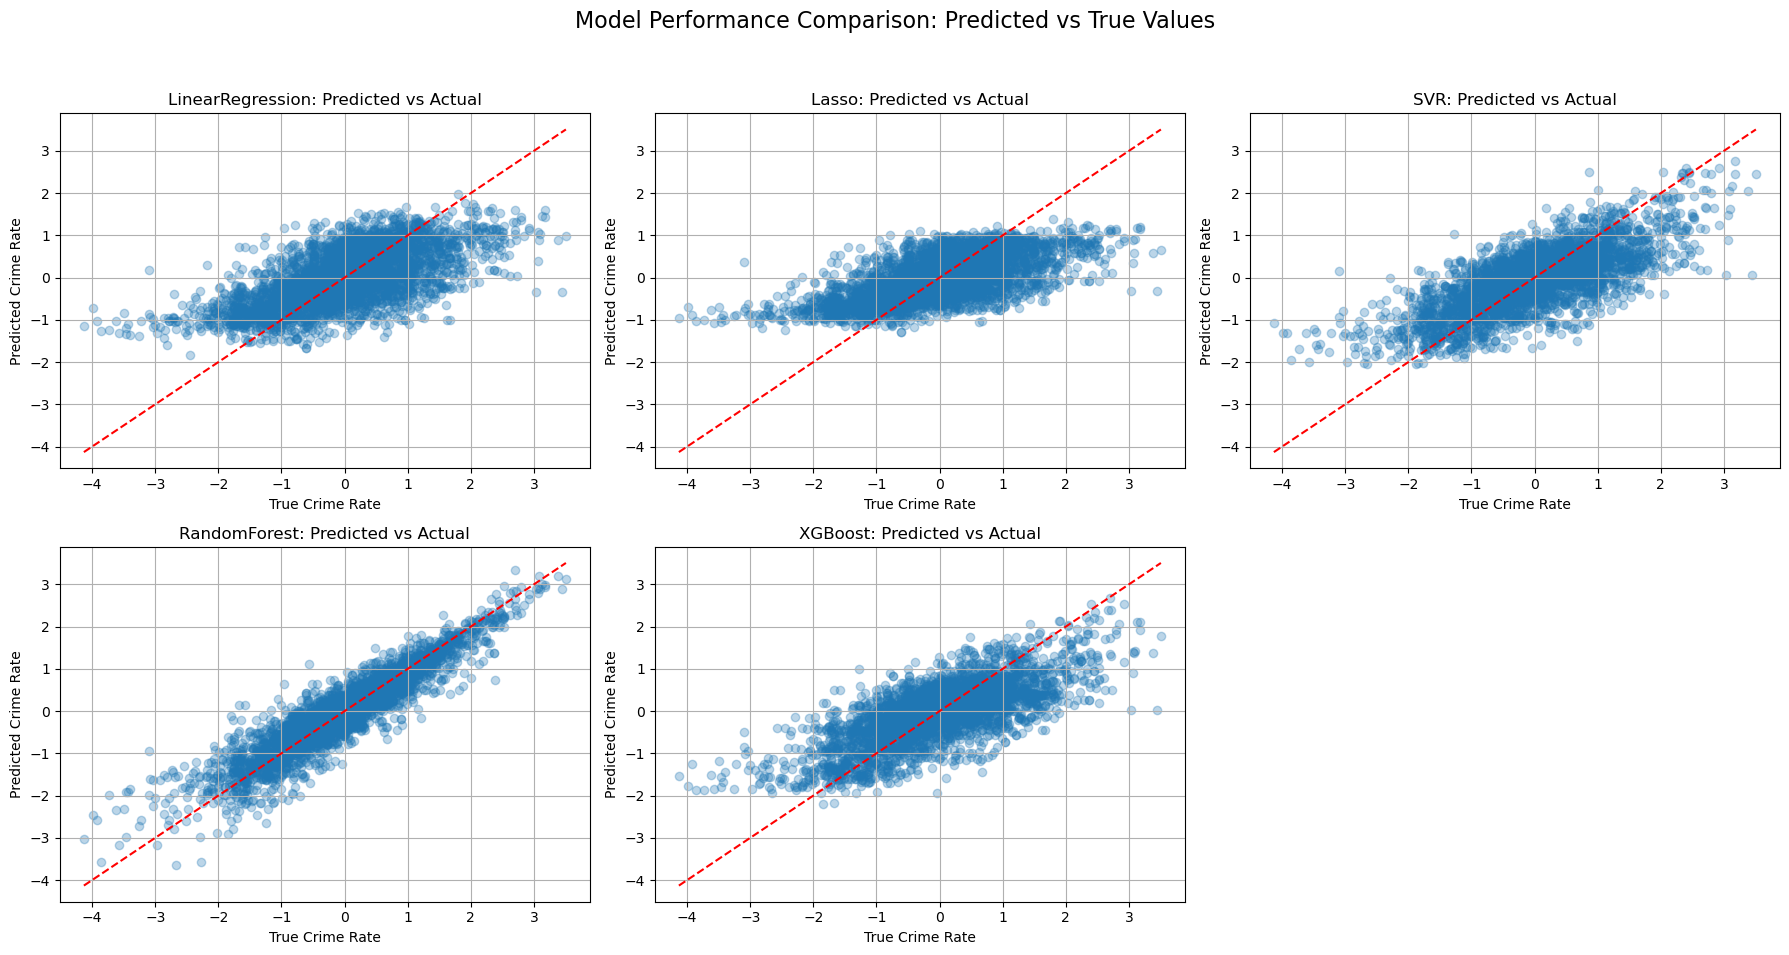

In [33]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10)) 
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test_scaled)
    ax = axes[i]
    ax.scatter(y_test, y_pred, alpha=0.3)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    ax.set_title(f"{name}: Predicted vs Actual")
    ax.set_xlabel("True Crime Rate")
    ax.set_ylabel("Predicted Crime Rate")
    ax.grid(True)

fig.delaxes(axes[-1])

plt.suptitle("Model Performance Comparison: Predicted vs True Values", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<div align="center"><strong>Figure 13.</strong> Predictions vs True Values </div>

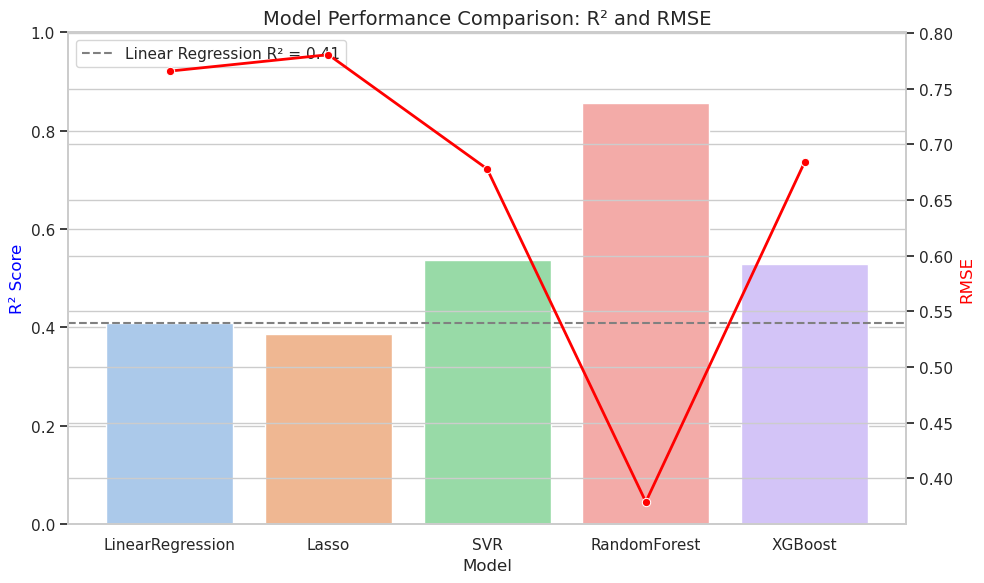

In [34]:
# Extract R² of linear regression as baseline
baseline_r2 = results_df[results_df["Model"] == "LinearRegression"]["R²"].values[0]

sns.set(style="whitegrid")
palette = sns.color_palette("pastel")

fig, ax1 = plt.subplots(figsize=(10, 6))

# R²  bar plot
palette = sns.color_palette("pastel")[:5]
sns.barplot(x="Model", y="R²", hue="Model", data=results_df, ax=ax1, palette=palette, legend=False)

ax1.set_ylabel("R² Score", color="blue")
ax1.set_ylim(0, 1.0)

# add baseline
ax1.axhline(baseline_r2, color='gray', linestyle='--', linewidth=1.5, label=f"Linear Regression R² = {baseline_r2:.2f}")
ax1.legend(loc='upper left')

# RMSE line plot
ax2 = ax1.twinx()
sns.lineplot(x="Model", y="RMSE", data=results_df, ax=ax2, color="red", marker="o", linewidth=2)
ax2.set_ylabel("RMSE", color="red")

plt.title("Model Performance Comparison: R² and RMSE", fontsize=14)
plt.tight_layout()
plt.show()

<div align="center"><strong>Figure 14.</strong> Model Performance Comparison: R² and RMSE </div>

The results reveal that: 

1. **Linear models** offer limited explanatory power (R² ≈ 0.4), suggesting that while structural variables are relevant to crime rate, many non-linear effects and interactions remain uncaptured. 
2. Non-linear models, particularly **Random Forest**, show substantial performance gains, highlighting the need to account for more complex patterns when modelling crime. 
3. **Lasso** performs worst in this context, likely due to the lack of sparsity in the selected features. 
4. **SVR** and **XGBoost** show moderate performance between Linear models and Random Forest. 


Overall, Random Forest or XGBoost is recommended when predicting.


#### Test Generalization Ability of Random Forest and XGBoost

In [35]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=5525),
    param_grid_rf,
    cv=3, scoring='r2', n_jobs=-1
)

grid_rf.fit(X_train_scaled, y_train)
print("Best RF params:", grid_rf.best_params_)
print("Best RF R² on CV:", grid_rf.best_score_)

Best RF params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best RF R² on CV: 0.8048535824517881


Although the Random Forest model achieved a high R² (0.8557) when refitted on the full dataset, the cross-validated score from GridSearchCV (R² = 0.8049) is more reliable, as it reflects the model’s average generalisation performance.

In [36]:
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1]
}

grid_xgb = GridSearchCV(
    XGBRegressor(random_state=5525, verbosity=0),
    param_grid_xgb,
    cv=3, scoring='r2', n_jobs=-1
)

grid_xgb.fit(X_train_scaled, y_train)
print("Best XGB params:", grid_xgb.best_params_)
print("Best XGB R² on CV:", grid_xgb.best_score_)

Best XGB params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Best XGB R² on CV: 0.7358687085463188


The best XGBoost R² on cross-validation was 0.7359, indicating that structural variables offer strong predictive power for crime rate, even though performance is slightly lower than that of Random Forest.

## 5. Results and discussion

[[ go back to the top ]](#Table-of-contents)

PC1 reflects broad socio-economic deprivation and is positively associated with crime. PC2 indicates urban connectivity, PC3 captures language isolation, and PC4 relates to health—each contributing differently to spatial crime variation.

Clustering results further reveal spatially distinct neighbourhood types, with high-crime areas concentrated in central London, suggesting persistent structural patterns.

While linear models show limited explanatory power, non-linear predictive models—especially Random Forest—perform substantially better.This performance difference highlights the complex non-linear relationship between structural characteristics and crime.


## 6. Conclusion

[[ go back to the top ]](#Table-of-contents)

This study shows that socio-economic structures shape crime patterns across London’s LSOAs to some extent. While linear models offer limited explanatory power—possibly due to non-linearity or missing variables—machine learning models achieve strong predictive performance, highlighting the value of structural data in forecasting crime.

However, the use of static 2021 census variables may limit temporal generalisability.

Future work may incorporate longitudinal data, geographically weighted regression (GWR), or non-linear interaction modelling to further enhance explanatory power.

## 7.References

[[ go back to the top ]](#Table-of-contents)

Cheng, T. and Chen, T. (2021) ‘Urban crime and security’, in Shi, W. et al. (eds) *Urban Informatics*. Singapore: Springer, pp. 213–228. doi: 10.1007/978-981-15-8983-6_14.

Cozens, P. (2008) ‘Crime prevention through environmental design in western australia: Planning for sustainable urban futures’, *International Journal of Sustainable Development and Planning - Int J Sustain Dev Plann*, 3, pp. 272–292. doi: 10.2495/SDP-V3-N3-272-292.

Finegan, M., Firth ,Nick and and Delgadillo, J. (2020) ‘Adverse impact of neighbourhood socioeconomic deprivation on psychological treatment outcomes: the role of area-level income and crime’, *Psychotherapy Research*, 30(4), pp. 546–554. doi: 10.1080/10503307.2019.1649500.

Freeman, R. B. (1999) ‘Chapter 52 The economics of crime’, in *Handbook of Labor Economics*. Elsevier, pp. 3529–3571. doi: 10.1016/S1573-4463(99)30043-2.

Gallison, J. K. and Andresen, M. A. (2017) ‘Crime and Public Transportation: A Case Study of Ottawa’s O-Train System’, *Canadian Journal of Criminology and Criminal Justice*, 59(1), pp. 94–122. doi: 10.3138/cjccj.2016.E35.

Lochner, L. and Moretti, E. (2004) ‘The Effect of Education on Crime: Evidence from Prison Inmates, Arrests, and Self-Reports’, *American Economic Review*, 94(1), pp. 155–189. doi: 10.1257/000282804322970751.

Pazzona, M. (2024) ‘Revisiting the Income Inequality-Crime Puzzle’, *World Development*, 176, p. 106520. doi: 10.1016/j.worlddev.2023.106520.

Reilly, B. and Witt, R. (1996) ‘Crime, deterrence and unemployment in England and wales: An empirical analysis’, *Bulletin of Economic Research*, 48(2), pp. 137–159. doi: 10.1111/j.1467-8586.1996.tb00629.x.

Tan, S.-Y. and Haining, R. (2016) ‘Crime victimization and the implications for individual health and wellbeing: A sheffield case study’, *Social Science & Medicine*, 167, pp. 128–139. doi: 10.1016/j.socscimed.2016.08.018.


In [37]:
end_time = time.time()
total_time = end_time - start_time

mins, secs = divmod(total_time, 60)
print(f"🕒 Notebook running time: {int(mins)} m {secs:.2f} s")

🕒 Notebook running time: 2 m 51.52 s


In [38]:
%load_ext watermark
%watermark
%watermark -iv

Last updated: 2025-04-21T11:48:18.261440+00:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.27.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 6.10.14-linuxkit
Machine     : aarch64
Processor   : aarch64
CPU cores   : 8
Architecture: 64bit

xgboost    : 2.1.1
sklearn    : 1.5.2
matplotlib : 3.8.4
json       : 2.0.9
nbformat   : 5.10.4
geopandas  : 1.0.1
requests   : 2.32.3
statsmodels: 0.14.3
seaborn    : 0.13.2
numpy      : 1.26.4
sys        : 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:25:01) [GCC 12.3.0]
pandas     : 2.2.2
IPython    : 8.27.0
kneed      : 0.8.5

